https://www.kaggle.com/abhranta/brain-tumor-detection-mri

In [7]:
import splitfolders
splitfolders.ratio("input_data", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values

Copying files: 3000 files [00:00, 4935.00 files/s]


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.layers import *

train_dir = '/content/output/train'
test_dir = '/content/output/test'
val_dir = '/content/output/val'

size = 128
cmode = "sparse"

train_gen = ImageDataGenerator(
    rescale=1 / 255.0,
    horizontal_flip=True,
    zoom_range=0.20,
    rotation_range=0.10, )


train_ds = train_gen.flow_from_directory(train_dir, target_size=(size, size), class_mode=cmode, batch_size=32)


val_gen = ImageDataGenerator(rescale=1 / 255.0)

val_ds = val_gen.flow_from_directory(val_dir, target_size=(size, size),  class_mode=cmode, batch_size=32)

test_gen = ImageDataGenerator(rescale=1 / 255.0)

test_ds = test_gen.flow_from_directory(test_dir, target_size=(size, size),  class_mode=cmode, batch_size=32)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [16]:
cls_names = list(train_ds.class_indices)

img_config = dict(cls_names = cls_names, size = train_ds.target_size)
img_config

{'cls_names': ['no', 'yes'], 'size': (128, 128)}

In [17]:
import joblib
joblib.dump(img_config, 'brainT.pkl' )

['brainT.pkl']

In [18]:
fm  = tf.keras.models.Sequential()
n_cls = len(cls_names)


fm.add(Conv2D(64,3,padding='same', activation='relu', input_shape = (size,size,3)  ))
fm.add(Conv2D(64,3,padding='same', activation='relu'  ))
fm.add(MaxPool2D())

fm.add(Conv2D(128,3,padding='same', activation='relu'  ))
fm.add(MaxPool2D())

fm.add(Flatten())
fm.add(Dense(32, activation='relu'))
fm.add(Dense(n_cls, activation='softmax'))

fm.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



PATH = "/content/drive/MyDrive/models/brain_Tumor_V2.h5"
chkpt = tf.keras.callbacks.ModelCheckpoint(PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
spe = len(train_ds.classes)/32
vspe = len(val_ds.classes)/32



In [19]:
H =  fm.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    batch_size=32,
    callbacks = [chkpt],
    steps_per_epoch=spe,
    validation_steps = vspe,
    epochs=20,)


Epoch 1/20
75/75 [==============================] - 20s 258ms/step - loss: 0.5953 - accuracy: 0.6871 - val_loss: 0.4640 - val_accuracy: 0.7900

Epoch 00001: val_accuracy improved from -inf to 0.79000, saving model to /content/drive/MyDrive/models/brain_Tumor_V2.h5
Epoch 2/20
75/75 [==============================] - 19s 255ms/step - loss: 0.4662 - accuracy: 0.7962 - val_loss: 0.5755 - val_accuracy: 0.7600

Epoch 00002: val_accuracy did not improve from 0.79000
Epoch 3/20
75/75 [==============================] - 19s 255ms/step - loss: 0.3870 - accuracy: 0.8383 - val_loss: 0.3327 - val_accuracy: 0.8467

Epoch 00003: val_accuracy improved from 0.79000 to 0.84667, saving model to /content/drive/MyDrive/models/brain_Tumor_V2.h5
Epoch 4/20
75/75 [==============================] - 19s 258ms/step - loss: 0.3463 - accuracy: 0.8550 - val_loss: 0.4475 - val_accuracy: 0.8000

Epoch 00004: val_accuracy did not improve from 0.84667
Epoch 5/20
75/75 [==============================] - 19s 255ms/step - 

In [20]:
model_test = tf.keras.models.load_model(PATH)

In [21]:
model_test.evaluate(test_ds)

10/10 [==============================] - 1s 88ms/step - loss: 0.1551 - accuracy: 0.9833


[0.15506523847579956, 0.9833333492279053]

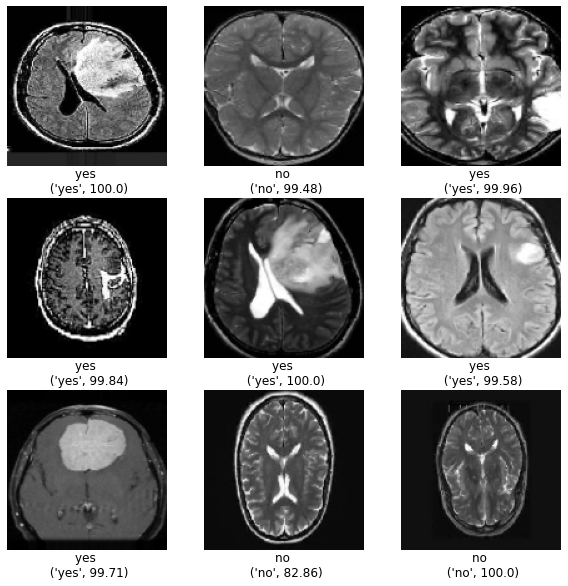

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plt_pred(model, IMG, conf_file):
    img = np.expand_dims(IMG, axis=0)
    pred = model.predict(img)
    score = np.max(pred)*100
    result = np.argmax(pred)
    cls_names = conf_file['cls_names']
    result = cls_names[result]
    score = round(score,2)
    return result,score


image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  actu_label = img_config['cls_names'][int(label_batch[i])]
  pred_l = plt_pred(fm, image_batch[i], img_config)
  ax.set_title(f'{actu_label} \n {pred_l}', y=-0.2)
  plt.axis("off")


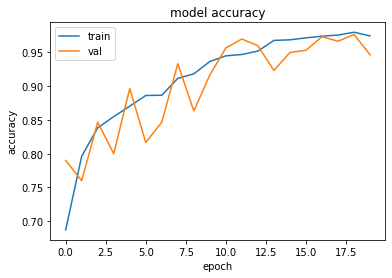

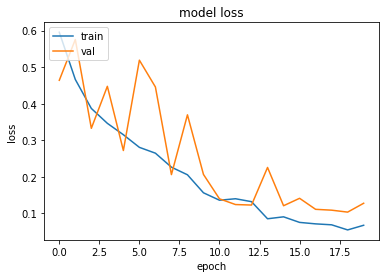

In [23]:
history = H

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




